In [1]:
#When running this code on colabratory, put this boolean to True. Else, put it to False
colabratory = True

if colabratory == True:
  #allow access to files
  from google.colab import drive
  drive.mount('/content/gdrive')

  #install missing packages
  !pip install aidapy
  !pip install h5netcdf

  #travel to correct directory
  %cd gdrive/MyDrive/Space-Weather_Project/version_300521/

Mounted at /content/gdrive
     |████████████████████████████████| 81kB 4.1MB/s 
     |████████████████████████████████| 6.1MB 12.5MB/s 
     |████████████████████████████████| 931kB 33.7MB/s 
     |████████████████████████████████| 71kB 8.2MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 184kB 43.4MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 1.3MB 33.6MB/s 
     |████████████████████████████████| 296kB 40.0MB/s 
     |████████████████████████████████| 143kB 42.2MB/s 
  Created wheel for cdflib: filename=cdflib-0.3.20-cp37-none-any.whl size=61621 sha256=436b2798f0f539c3ab480a612ac7b33e0f9e1f5ab2ec55642e4e61ded6acd0b5
  Stored in directory: /root/.cache/pip/wheels/25/4c/dc/1404d995ed272eee423f1ecab3274fe367488a95aa71f4a06a
  Created wheel fo

In [2]:
%run notebook_setup.py

Creating download directory /root/heliopy/data


In [3]:
import csv

In [4]:
log_dir = './results/mlp_run_26-05-2021_batchnorm_dropfrac/'
if not os.path.isdir(os.path.join(log_dir,'figures')):
    os.makedirs(os.path.join(log_dir,'figures'))

### Split sets

In [5]:
ml_method = 'mlp'
data_version = 'mms1_samp_4dot5s' 
data_process = 'no_flux_shuffle' #_znorm' 
period = '2016_2018'

x_train, y_train, x_test, y_test, x_val, y_val = l_tools.generate_train_test(
    ml_method, 
    data_version, 
    data_process, 
    period)

### Convert categorical

In [6]:
y_train_cat = keras.utils.to_categorical(y_train)
y_test_cat  = keras.utils.to_categorical(y_test)
y_val_cat   = keras.utils.to_categorical(y_val)


print('>> TRAINING DATASET \t',
      x_train.shape,'\t\t',
      y_train.shape,'\t',
      y_train_cat.shape)
print('>> VALIDATION DATASET \t',
      x_val.shape,'\t\t',
      y_val.shape,'\t',
      y_val_cat.shape)
print('>> TEST DATASET \t',
      x_test.shape,'\t\t',
      y_test.shape,'\t',
      y_test_cat.shape)

>> TRAINING DATASET 	 (748761, 12) 		 (748761,) 	 (748761, 10)
>> VALIDATION DATASET 	 (249588, 12) 		 (249588,) 	 (249588, 10)
>> TEST DATASET 	 (332784, 12) 		 (332784,) 	 (332784, 10)


### Load MLP

In [7]:
model = keras.models.load_model(os.path.join(log_dir, 'model.h5'))
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 12)]              0         
_________________________________________________________________
dense (Dense)                (None, 128)               1664      
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
activation (Activation)      (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512   

#### Load training information

In [8]:

acc = []
val_acc = []
loss = []
val_loss = []

with open(os.path.join(log_dir,'training.csv')) as csv_file:
  csv_reader = csv.reader(csv_file, delimiter=',')
  line_count = 0
  for row in csv_reader:
        if line_count == 0:
          line_count += 1
        else:
          acc.append(float(row[1]))
          loss.append(float(row[2]))
          val_acc.append(float(row[3]))
          val_loss.append(float(row[4]))
          line_count += 1

### Display Training loss and accuracy

findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.


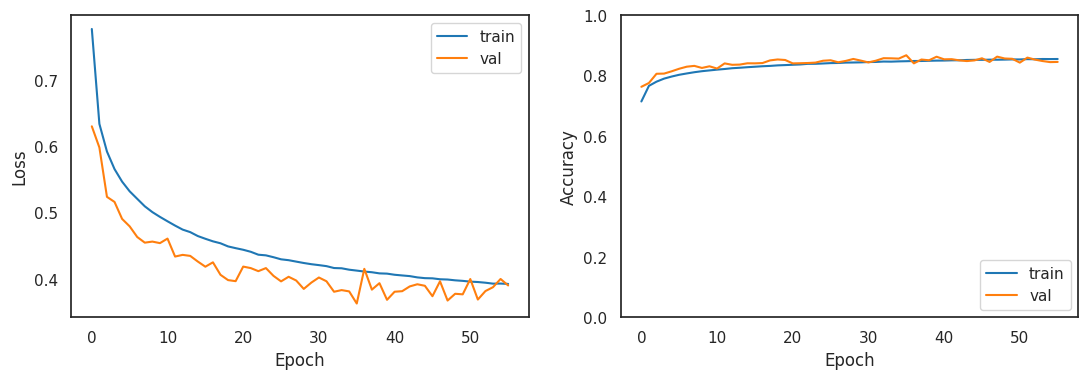

In [9]:
plt.close('all')
plt.figure(num=1, figsize=(13, 4))

plt.subplot(121)
plt.plot(loss)
plt.plot(val_loss)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper right')
#plt.grid('on')


plt.subplot(122)
plt.plot(acc)
plt.plot(val_acc)
plt.ylim(0.0, 1.0)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='lower right')
#plt.grid('on')

plt.savefig(os.path.join(log_dir,'figures/loss_acc_MLP.png'),format = 'PNG')

### Display confusion matrices

In [10]:
def convert_from_categorical(y_categorical):
    y_categorical = y_categorical / np.sum(y_categorical, axis=1).reshape((-1,1))
    y = np.argmax(y_categorical, axis=1)
    #edited to also return the score (Lukas)
    return y, y_categorical

#y_pred_cat = model.predict(x_test)
# or saved: 
y_pred_cat = model.predict(x_test)


#edited to also assign the score (Lukas)
y_pred,y_score = convert_from_categorical(y_pred_cat)

In [12]:
cf_matrix_cnt = sklearn.metrics.confusion_matrix(y_test, y_pred, labels=m_classnames_id)

temporary_vector = cf_matrix_cnt.sum(axis=1).astype("float"); 
temporary_vector[temporary_vector==0]=np.nan
cf_matrix = cf_matrix_cnt.astype("float")/temporary_vector[:,np.newaxis]

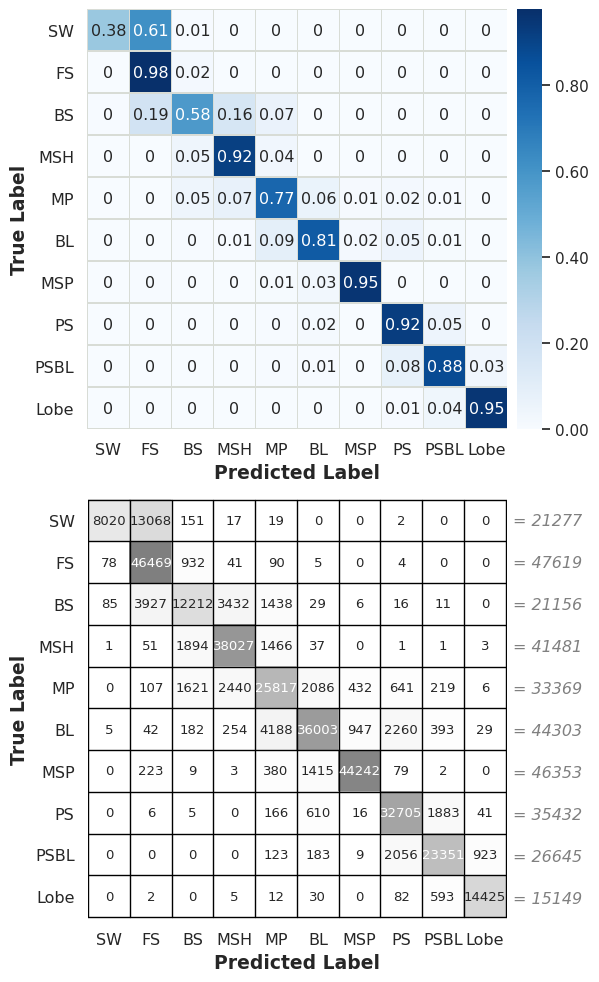

In [16]:
plt.close('all')
plot_conf_mat(cf_matrix_cnt, cf_matrix, m_classnames, txt_size=11.5)
#manual save required

(array([  98.,  105.,   96.,  107.,   94.,  111.,  127.,  121.,  128.,
         108.,  126.,  125.,  120.,  129.,  130.,  141.,  135.,  133.,
         155.,  125.,  125.,  154.,  145.,  134.,  143.,  136.,  144.,
         155.,  169.,  161.,  169.,  168.,  174.,  173.,  181.,  170.,
         194.,  198.,  195.,  183.,  212.,  231.,  200.,  233.,  230.,
         268.,  236.,  260.,  294.,  303.,  293.,  301.,  301.,  313.,
         286.,  277.,  329.,  320.,  288.,  322.,  283.,  292.,  356.,
         341.,  352.,  369.,  386.,  402.,  424.,  398.,  473.,  449.,
         471.,  538.,  552.,  536.,  594.,  620.,  708.,  707.,  703.,
         803.,  871., 1003., 1079., 1139., 1321., 1449., 1600., 1729.,
        2039., 2383., 2494., 2849., 3308., 3535., 3864., 4063., 4455.,
        2775.]),
 array([1.85847282e-04, 1.01772826e-02, 2.01687180e-02, 3.01601533e-02,
        4.01515886e-02, 5.01430258e-02, 6.01344593e-02, 7.01258928e-02,
        8.01173300e-02, 9.01087672e-02, 1.00100204e-01, 1.

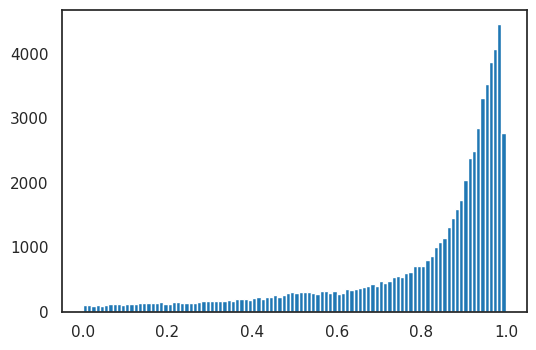

In [33]:
#investigate the scores of SW
difflist = abs(y_score[y_pred==1][:,1]-y_score[y_pred==1][:,0])

plt.hist(difflist,bins=100)

### Display classification report

In [14]:
report = sklearn.metrics.classification_report(y_test, y_pred)
print(report)
with open(os.path.join(log_dir,'figures/class_report_MLP.txt'), 'w') as f:
    print(report, file=f) 

              precision    recall  f1-score   support

         0.0       0.98      0.38      0.54     21277
         1.0       0.73      0.98      0.83     47619
         2.0       0.72      0.58      0.64     21156
         3.0       0.86      0.92      0.89     41481
         4.0       0.77      0.77      0.77     33369
         5.0       0.89      0.81      0.85     44303
         6.0       0.97      0.95      0.96     46353
         7.0       0.86      0.92      0.89     35432
         8.0       0.88      0.88      0.88     26645
         9.0       0.94      0.95      0.94     15149

    accuracy                           0.85    332784
   macro avg       0.86      0.81      0.82    332784
weighted avg       0.86      0.85      0.84    332784



In [ ]:
#makes a table in LaTeX syntax
def makeTable(data, header, c):
  n = len(data)

  print(makeRow(header, c))
  for i in range(n):
    print(makeRow(data[i], c))

#makes one row for a table in LaTeX syntax
def makeRow(row, c):
  num = '$'
  beg = ''
  mid = '&'
  end = '\\\\'

  string = ''
  for j in range(c):
    isnum = isFloat(row[j])
    if isnum:
      string += num
    string += " "+ str(row[j]) + " "
    if isnum:
      string += num
    if j < c-1:
      string += mid
    else:
      string += end
  return(string)

#checks if the argument is a float or a string
def isFloat(test):
  try:
    float(test)
  except:
    return False
  else:
    return True

In [ ]:
# turn 'report'-string into a list
temp = report.split(' ')
res = [[]]
index = 0
for stri in temp:
  if stri != '':
    if '\n' in stri:
      stri = stri.replace('\n', '')
      res[-1].append(stri)
      res.append([])
    else:
      res[-1].append(stri)
print(res)

# make corrections so that we can use it for a table
head = [' '] + res[0]
dat = res[1:-1]

temp = dat[-2][-1].split('w')
for i in range(0, 10):
  dat[i][0] = association[int(float(dat[i][0]))].upper()
dat[-2][-1] = temp[0]
dat[-1][0] = 'w'+temp[1]+" "+dat[-1][0]
dat[-2] = [dat[-2][0]+' '+dat[-2][1]]+dat[-2][2:]

dat[-3] = [dat[-3][0]] + [' ', ' '] + dat[-3][1:]

[['precision', 'recall', 'f1-score', 'support'], ['0.0', '0.98', '0.38', '0.54', '21277'], ['1.0', '0.73', '0.98', '0.83', '47619'], ['2.0', '0.72', '0.58', '0.64', '21156'], ['3.0', '0.86', '0.92', '0.89', '41481'], ['4.0', '0.77', '0.77', '0.77', '33369'], ['5.0', '0.89', '0.81', '0.85', '44303'], ['6.0', '0.97', '0.95', '0.96', '46353'], ['7.0', '0.86', '0.92', '0.89', '35432'], ['8.0', '0.88', '0.88', '0.88', '26645'], ['9.0', '0.94', '0.95', '0.94', '15149'], ['accuracy', '0.85', '332784'], ['macro', 'avg', '0.86', '0.81', '0.82', '332784weighted'], ['avg', '0.86', '0.85', '0.84', '332784'], []]


In [ ]:
makeTable(dat, head, 5)

   & precision & recall & f1-score & support \\
 SW &$ 0.98 $&$ 0.38 $&$ 0.54 $&$ 21277 $\\
 FS &$ 0.73 $&$ 0.98 $&$ 0.83 $&$ 47619 $\\
 BS &$ 0.72 $&$ 0.58 $&$ 0.64 $&$ 21156 $\\
 MSH &$ 0.86 $&$ 0.92 $&$ 0.89 $&$ 41481 $\\
 MP &$ 0.77 $&$ 0.77 $&$ 0.77 $&$ 33369 $\\
 BL &$ 0.89 $&$ 0.81 $&$ 0.85 $&$ 44303 $\\
 MSP &$ 0.97 $&$ 0.95 $&$ 0.96 $&$ 46353 $\\
 PS &$ 0.86 $&$ 0.92 $&$ 0.89 $&$ 35432 $\\
 PSBL &$ 0.88 $&$ 0.88 $&$ 0.88 $&$ 26645 $\\
 LOBE &$ 0.94 $&$ 0.95 $&$ 0.94 $&$ 15149 $\\
 accuracy &   &   &$ 0.85 $&$ 332784 $\\
 macro avg &$ 0.86 $&$ 0.81 $&$ 0.82 $&$ 332784 $\\
 weighted avg &$ 0.86 $&$ 0.85 $&$ 0.84 $&$ 332784 $\\


### Display ROC curves

n_classes 10


findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


AUC macro average :0.989534843172798
AUC micro average :0.990926329834351


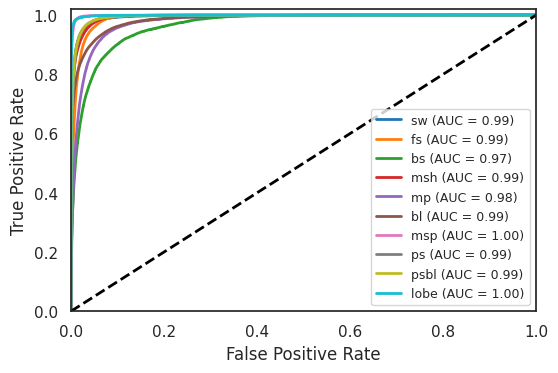

In [15]:
fig_ROC = l_tools.roc_plot(y_score, y_test, association=association)
plt.savefig(os.path.join(log_dir,'figures/ROC_MLP.eps'),format='eps')
plt.show()